In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview
You should consider upgrading via the 'd:\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0-dev20200925


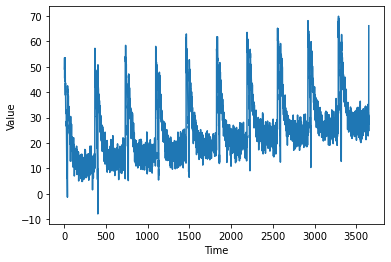

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 5s 13ms/step - loss: 17.9235 - mae: 18.4235
Epoch 2/100
94/94 [==============================] - 1s 13ms/step - loss: 18.1005 - mae: 18.6005
Epoch 3/100
94/94 [==============================] - 1s 13ms/step - loss: 17.9976 - mae: 18.4976
Epoch 4/100
94/94 [==============================] - 1s 14ms/step - loss: 17.8102 - mae: 18.3102
Epoch 5/100
94/94 [==============================] - 1s 13ms/step - loss: 17.9366 - mae: 18.4366
Epoch 6/100
94/94 [==============================] - 2s 16ms/step - loss: 17.7680 - mae: 18.2680: 0s - loss: 15.999
Epoch 7/100
94/94 [==============================] - 1s 14ms/step - loss: 17.8528 - mae: 18.3528
Epoch 8/100
94/94 [==============================] - 1s 14ms/step - loss: 17.6084 - mae: 18.1084
Epoch 9/100
94/94 [==============================] - 1s 15ms/step - loss: 17.7662 - mae: 18.2662
Epoch 10/100
94/94 [==============================] - 1s 14ms/step - loss: 17.5260 - mae: 18.0260
Epoch 11/1

94/94 [==============================] - 2s 23ms/step - loss: 2.9578 - mae: 3.4222
Epoch 83/100
94/94 [==============================] - 2s 22ms/step - loss: 2.9833 - mae: 3.4438
Epoch 84/100
94/94 [==============================] - 2s 22ms/step - loss: 2.8138 - mae: 3.2794: 0s - loss: 2.7857 - mae: 3.
Epoch 85/100
94/94 [==============================] - 2s 21ms/step - loss: 2.9776 - mae: 3.4427
Epoch 86/100
94/94 [==============================] - 2s 16ms/step - loss: 2.8935 - mae: 3.3567
Epoch 87/100
94/94 [==============================] - 1s 15ms/step - loss: 3.0446 - mae: 3.5085
Epoch 88/100
94/94 [==============================] - 2s 22ms/step - loss: 2.8009 - mae: 3.2641:
Epoch 89/100
94/94 [==============================] - 2s 24ms/step - loss: 2.9918 - mae: 3.4602
Epoch 90/100
94/94 [==============================] - 2s 25ms/step - loss: 3.0467 - mae: 3.5146
Epoch 91/100
94/94 [==============================] - 2s 25ms/step - loss: 2.7862 - mae: 3.2503: 0s - loss: 2.
Epoch 92

(1e-08, 0.0001, 0.0, 30.0)

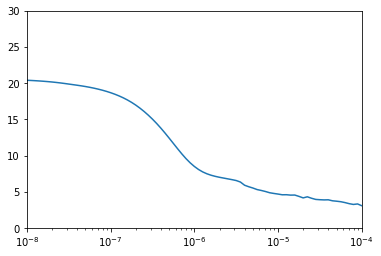

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 6s 13ms/step - loss: 621.4112 - mae: 17.3184
Epoch 2/500
94/94 [==============================] - 1s 14ms/step - loss: 35.4448 - mae: 3.9949
Epoch 3/500
94/94 [==============================] - 1s 15ms/step - loss: 24.7060 - mae: 3.3967
Epoch 4/500
94/94 [==============================] - 2s 20ms/step - loss: 27.9481 - mae: 3.7105
Epoch 5/500
94/94 [==============================] - 1s 14ms/step - loss: 25.3553 - mae: 3.5254
Epoch 6/500
94/94 [==============================] - 1s 15ms/step - loss: 23.1941 - mae: 3.3501
Epoch 7/500
94/94 [==============================] - 1s 14ms/step - loss: 29.9593 - mae: 3.9666
Epoch 8/500
94/94 [==============================] - 1s 14ms/step - loss: 27.3687 - mae: 3.7184
Epoch 9/500
94/94 [==============================] - 1s 15ms/step - loss: 22.7929 - mae: 3.4158
Epoch 10/500
94/94 [==============================] - 2s 20ms/step - loss: 24.3466 - mae: 3.4988 0s - loss: 24.2250 - mae: 3.49
Epoch 

94/94 [==============================] - 1s 15ms/step - loss: 26.0169 - mae: 3.6776
Epoch 84/500
94/94 [==============================] - 1s 14ms/step - loss: 19.3934 - mae: 3.0728
Epoch 85/500
94/94 [==============================] - 1s 15ms/step - loss: 20.4156 - mae: 3.0422 0s - los
Epoch 86/500
94/94 [==============================] - 1s 15ms/step - loss: 19.5550 - mae: 3.0909
Epoch 87/500
94/94 [==============================] - 2s 16ms/step - loss: 23.7012 - mae: 3.3429
Epoch 88/500
94/94 [==============================] - 2s 19ms/step - loss: 19.6335 - mae: 3.0113
Epoch 89/500
94/94 [==============================] - 2s 17ms/step - loss: 20.6737 - mae: 3.1397
Epoch 90/500
94/94 [==============================] - 2s 18ms/step - loss: 21.0678 - mae: 3.2109
Epoch 91/500
94/94 [==============================] - 2s 17ms/step - loss: 19.2577 - mae: 3.0604
Epoch 92/500
94/94 [==============================] - 2s 19ms/step - loss: 24.6516 - mae: 3.3844
Epoch 93/500
94/94 [==============

94/94 [==============================] - 2s 18ms/step - loss: 25.4020 - mae: 3.5896
Epoch 166/500
94/94 [==============================] - 2s 21ms/step - loss: 17.6150 - mae: 2.9410
Epoch 167/500
94/94 [==============================] - 2s 25ms/step - loss: 20.9275 - mae: 3.0583
Epoch 168/500
94/94 [==============================] - 3s 26ms/step - loss: 20.7558 - mae: 3.1883
Epoch 169/500
94/94 [==============================] - 2s 23ms/step - loss: 18.7278 - mae: 3.0589
Epoch 170/500
94/94 [==============================] - 2s 19ms/step - loss: 18.9149 - mae: 2.9938- ETA: 0s - los
Epoch 171/500
94/94 [==============================] - 2s 19ms/step - loss: 18.7565 - mae: 3.0190
Epoch 172/500
94/94 [==============================] - 2s 19ms/step - loss: 18.1085 - mae: 2.9047
Epoch 173/500
94/94 [==============================] - 2s 19ms/step - loss: 21.5411 - mae: 3.0996 0s - los
Epoch 174/500
94/94 [==============================] - 2s 18ms/step - loss: 18.2533 - mae: 2.9807
Epoch 175/

94/94 [==============================] - 2s 17ms/step - loss: 18.1102 - mae: 3.0117 0s - loss: 17.3364 - mae
Epoch 247/500
94/94 [==============================] - 2s 18ms/step - loss: 17.1698 - mae: 2.8732
Epoch 248/500
94/94 [==============================] - 2s 17ms/step - loss: 21.8866 - mae: 3.2344
Epoch 249/500
94/94 [==============================] - 2s 17ms/step - loss: 19.8420 - mae: 2.9233
Epoch 250/500
94/94 [==============================] - 2s 16ms/step - loss: 18.2627 - mae: 2.9378
Epoch 251/500
94/94 [==============================] - 2s 17ms/step - loss: 19.3458 - mae: 3.1649
Epoch 252/500
94/94 [==============================] - 2s 17ms/step - loss: 21.8504 - mae: 3.0883
Epoch 253/500
94/94 [==============================] - 2s 16ms/step - loss: 18.7709 - mae: 2.9642
Epoch 254/500
94/94 [==============================] - 2s 17ms/step - loss: 18.2043 - mae: 3.0000
Epoch 255/500
94/94 [==============================] - 2s 17ms/step - loss: 20.1470 - mae: 3.0553
Epoch 256

94/94 [==============================] - 2s 21ms/step - loss: 21.0258 - mae: 2.9758
Epoch 329/500
94/94 [==============================] - 2s 24ms/step - loss: 21.9408 - mae: 3.2718
Epoch 330/500
94/94 [==============================] - 2s 23ms/step - loss: 20.4007 - mae: 3.1561
Epoch 331/500
94/94 [==============================] - 2s 20ms/step - loss: 18.5349 - mae: 2.9988
Epoch 332/500
94/94 [==============================] - 2s 17ms/step - loss: 17.6009 - mae: 2.8854
Epoch 333/500
94/94 [==============================] - 2s 18ms/step - loss: 20.8469 - mae: 3.0469
Epoch 334/500
94/94 [==============================] - 2s 17ms/step - loss: 19.5428 - mae: 3.0628
Epoch 335/500
94/94 [==============================] - 2s 18ms/step - loss: 17.2883 - mae: 2.9530 0s - loss: 16.5810 - m
Epoch 336/500
94/94 [==============================] - 2s 18ms/step - loss: 21.1121 - mae: 3.0056
Epoch 337/500
94/94 [==============================] - 2s 18ms/step - loss: 22.0277 - mae: 3.0364
Epoch 338/5

94/94 [==============================] - 3s 27ms/step - loss: 21.1458 - mae: 3.1657
Epoch 410/500
94/94 [==============================] - 2s 26ms/step - loss: 19.4085 - mae: 2.9898
Epoch 411/500
94/94 [==============================] - 2s 23ms/step - loss: 17.8576 - mae: 2.9459
Epoch 412/500
94/94 [==============================] - 2s 19ms/step - loss: 18.6151 - mae: 2.9605
Epoch 413/500
94/94 [==============================] - 2s 19ms/step - loss: 21.0615 - mae: 3.1068
Epoch 414/500
94/94 [==============================] - 2s 24ms/step - loss: 21.2659 - mae: 3.1026
Epoch 415/500
94/94 [==============================] - 2s 24ms/step - loss: 19.2765 - mae: 3.0694
Epoch 416/500
94/94 [==============================] - 2s 21ms/step - loss: 22.0725 - mae: 3.0407
Epoch 417/500
94/94 [==============================] - 2s 21ms/step - loss: 20.8487 - mae: 3.0349
Epoch 418/500
94/94 [==============================] - 2s 19ms/step - loss: 16.4272 - mae: 2.8885
Epoch 419/500
94/94 [=============

94/94 [==============================] - 2s 17ms/step - loss: 19.8114 - mae: 2.9486 0s - loss: 19.6402
Epoch 492/500
94/94 [==============================] - 2s 17ms/step - loss: 22.0935 - mae: 3.2515
Epoch 493/500
94/94 [==============================] - 2s 17ms/step - loss: 17.7482 - mae: 2.8850
Epoch 494/500
94/94 [==============================] - 2s 16ms/step - loss: 18.7005 - mae: 2.9524
Epoch 495/500
94/94 [==============================] - 2s 17ms/step - loss: 18.5885 - mae: 2.8785
Epoch 496/500
94/94 [==============================] - 2s 17ms/step - loss: 16.9311 - mae: 2.9105
Epoch 497/500
94/94 [==============================] - 2s 22ms/step - loss: 19.7239 - mae: 2.9401
Epoch 498/500
94/94 [==============================] - 2s 20ms/step - loss: 21.3044 - mae: 3.0713
Epoch 499/500
94/94 [==============================] - 2s 20ms/step - loss: 22.5014 - mae: 3.1115
Epoch 500/500
94/94 [==============================] - 2s 19ms/step - loss: 20.6938 - mae: 3.0112


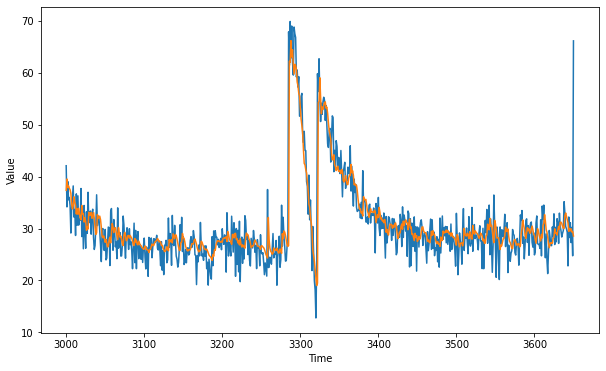

In [8]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.920535

<Figure size 432x288 with 0 Axes>

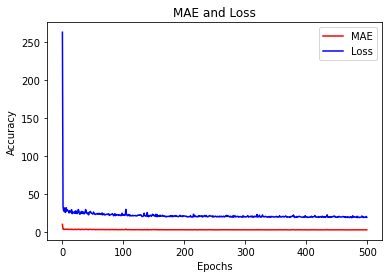

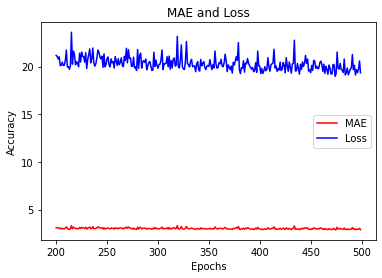

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()